In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
from datetime import datetime, timedelta
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import yfinance as yf

In [3]:
#Download data

end_date = datetime.today()
# start_date = end_date + timedelta(days=-5*365)
start_date = datetime(2000, 1, 1)


spx = yf.download("^GSPC", start=start_date, end=end_date)

hist_close = spx['Close']
hist_ret = hist_close / hist_close.shift(1) - 1.0     # shift 1 shifts forward one day; today has yesterday's price
# hist_ret = hist_close.pct_change(1)
hist_ret.dropna(inplace=True)
hist_ret = hist_ret * 100.0
print(hist_ret.describe())
print(f'Skew: {scipy.stats.skew(hist_ret)}, Kurtosis: {scipy.stats.kurtosis(hist_ret)}')

[*********************100%***********************]  1 of 1 completed

Ticker        ^GSPC
count   6555.000000
mean       0.031363
std        1.218805
min      -11.984055
25%       -0.472371
50%        0.064279
75%        0.589109
max       11.580037
Skew: [-0.12139573], Kurtosis: [10.49983121]


In [4]:
#ARIMA Model

#Step One: Identify (p, d, q)

# price is known to be non-stationary; return is stationary
from statsmodels.tsa.stattools import adfuller

result = adfuller(hist_close)
print(f'ADF Statistic: {result[0]}, p-value: {result[1]}')  # null hypothesis: unit root exists; can't reject null.

result = adfuller(hist_ret)
print(f'ADF Statistic: {result[0]}, p-value: {result[1]}')   # reject null hypothesis of unit root ==> stationary          


ADF Statistic: 2.9873696977019706, p-value: 1.0
ADF Statistic: -15.301313639891298, p-value: 4.308866066276269e-28


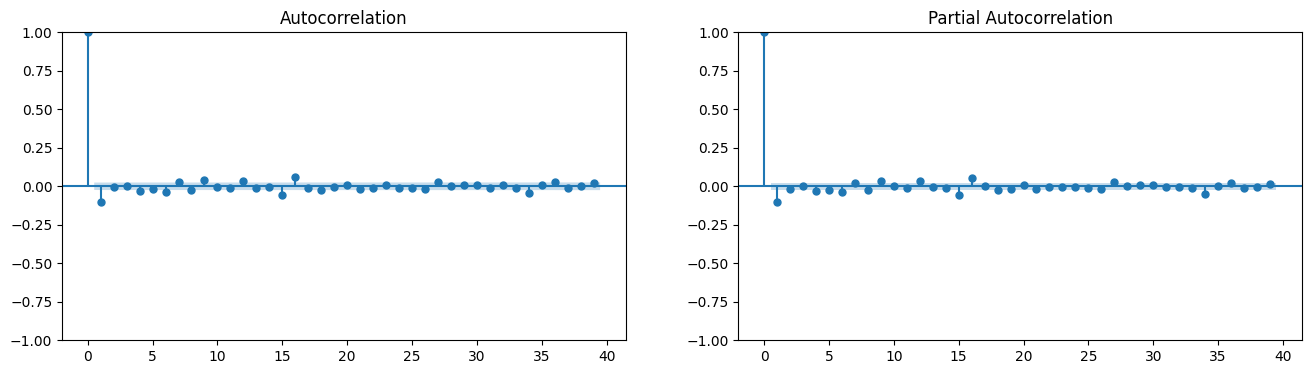

        acf      pacf
1 -0.101478 -0.101494
2 -0.006607 -0.017086
3  0.002009 -0.000411
4 -0.029905 -0.030190
5 -0.014717 -0.021112


In [5]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(16, 4))
plot_acf(hist_ret, ax=axes[0])          # determines MA(q)
plot_pacf(hist_ret, ax=axes[1])         # determines AR(p)
plt.show()

act_stats = acf(hist_ret, fft=False)[1:40]                
acf_df = pd.DataFrame([act_stats]).T
acf_df.columns = ['acf']
acf_df.index += 1

pacf_stats = pacf(hist_ret)[1:40]                        
pacf_df = pd.DataFrame([pacf_stats]).T
pacf_df.columns = ['pacf']
pacf_df.index += 1

df_acf_pcaf = pd.concat([acf_df, pacf_df], axis=1)
print(df_acf_pcaf.head())

In [6]:
# acf/pacf suggests higher order of arounds 35 business days, which makes the model practically unusable.
# instead, let's constraint the order to 5 business days and use AIC to pick up the best fit

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima.model import ARIMA

# Clean the series
hist_training = hist_ret.iloc[:-45].dropna()
hist_testing  = hist_ret.iloc[-45:].dropna()

dict_aic = {}

for p in range(6):
    for q in range(6):
        try:
            model = ARIMA(hist_training, order=(p, 0, q))
            model_fit = model.fit()
            dict_aic[(p, q)] = model_fit.aic
        except Exception as e:
            print(f"ARIMA({p},0,{q}) failed: {e}")

df_aic = pd.DataFrame.from_dict(dict_aic, orient='index', columns=['aic'])

if df_aic.empty:
    raise ValueError("No ARIMA models could be fitted. Check your data.")

# Extract best (p,q)
p, q = df_aic.aic.idxmin()

print(f"Best ARIMA order is ({p}, 0, {q})")


Best ARIMA order is (5, 0, 4)


In [7]:
#Step Two: Fit the Model
	
# train the selected model


model = ARIMA(hist_training, order=(p, 0, q))
arima_fitted = model.fit()   # no disp argument
arima_fitted.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  ^GSPC   No. Observations:                 6510
Model:                 ARIMA(5, 0, 4)   Log Likelihood              -10485.360
Date:                Tue, 27 Jan 2026   AIC                          20992.720
Time:                        19:32:49   BIC                          21067.312
Sample:                             0   HQIC                         21018.517
                               - 6510                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0309      0.014      2.206      0.027       0.003       0.058
ar.L1         -0.5036      0.063     -7.989      0.000      -0.627      -0.380
ar.L2          0.8714      0.065     13.356      0.000       0.744       0.999
ar.L3         -0.1015      0.064     -1.575      0.115      -0.228       0.025
ar.L4         -0.8149      0.056    -14.424      0.000      -0.926      -0.704
ar.L5         -0.1047      0.009    -11.902      0.000      -0.122      -0.087
ma.L1          0.4029      0.064      6.298      0.000       0.277       0.528
ma.L2         -0.9241      0.064    -14.534      0.000      -1.049      -0.799
ma.L3          0.1961      0.067      2.910      0.004       0.064       0.328
ma.L4          0.7652      0.055     13.970      0.000       0.658       0.873
sigma2         1.4673      0.012    126.027      0.000       1.444       1.490
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             24089.24
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -0.31
Prob(H) (two-sided):                  0.21   Kurtosis:                        12.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

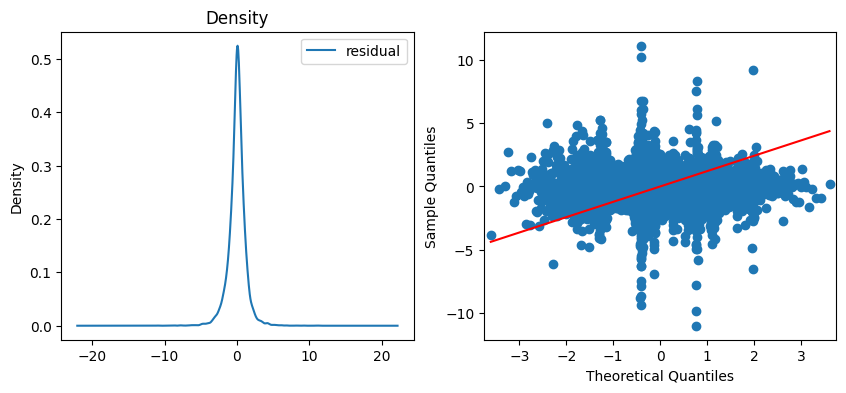

Statistics=1201.255, p=0.000
Statistics=0.905, p=0.000


In [9]:
#Step Three: Residual Analysis


residuals = pd.DataFrame(arima_fitted.resid, columns=['residual'])
fig, ax = plt.subplots(1,2, figsize=(10, 4))
# residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[0])
sm.qqplot(residuals, line='s', ax=ax[1])
plt.show()

# normality test
from scipy.stats import shapiro, normaltest
stat, p = normaltest(residuals)
print(f'Statistics={stat[0]:.3f}, p={p[0]:.3f}')       # H0: Gaussian
stat, p = shapiro(residuals)
print(f'Statistics={stat:.3f}, p={p:.3f}')       # H0: Gaussian

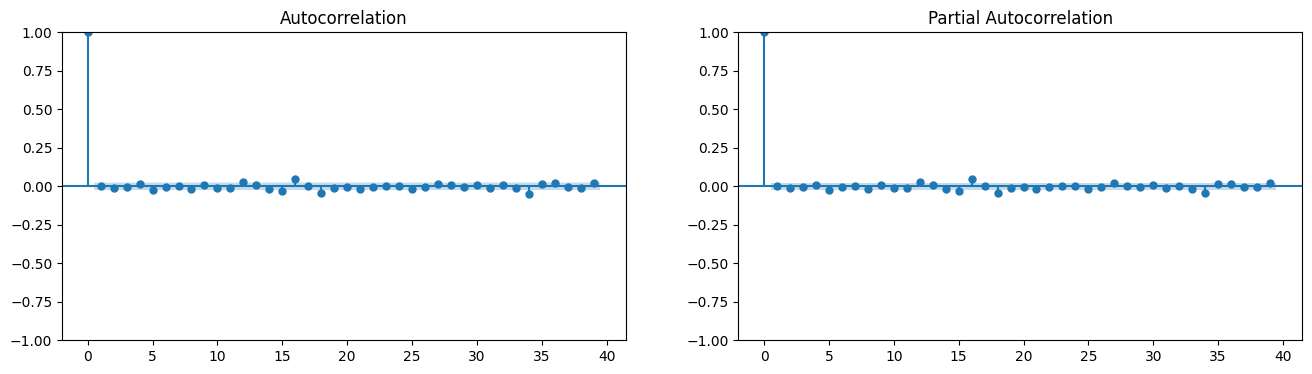

In [10]:
# Because we limit the lag orders; there still has remaining autocorrelation.
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(residuals, ax=axes[0])
plot_pacf(residuals, ax=axes[1])
plt.show()

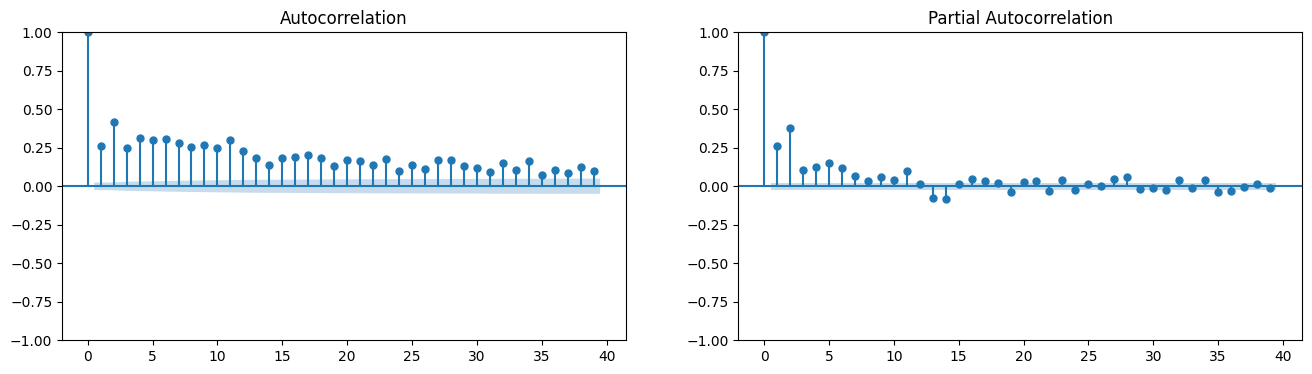

In [11]:
# In addition, There exists autocorrelation in squared residuals, suggesting GARCH
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(residuals**2, ax=axes[0])
plot_pacf(residuals**2, ax=axes[1])
plt.show()

In [12]:
#Step Four: Forecast



return_predicted = arima_fitted.predict()

# Convert predicted returns into a price path
price_predicted = hist_close.iloc[0] * np.cumprod(1 + return_predicted)


In [13]:
n_steps = hist_testing.shape[0]

# Get forecast object
forecast_obj = arima_fitted.get_forecast(steps=n_steps)

# Extract components
forecasted = forecast_obj.predicted_mean
forecasted_std = forecast_obj.se_mean
forecasted_bounds = forecast_obj.conf_int()


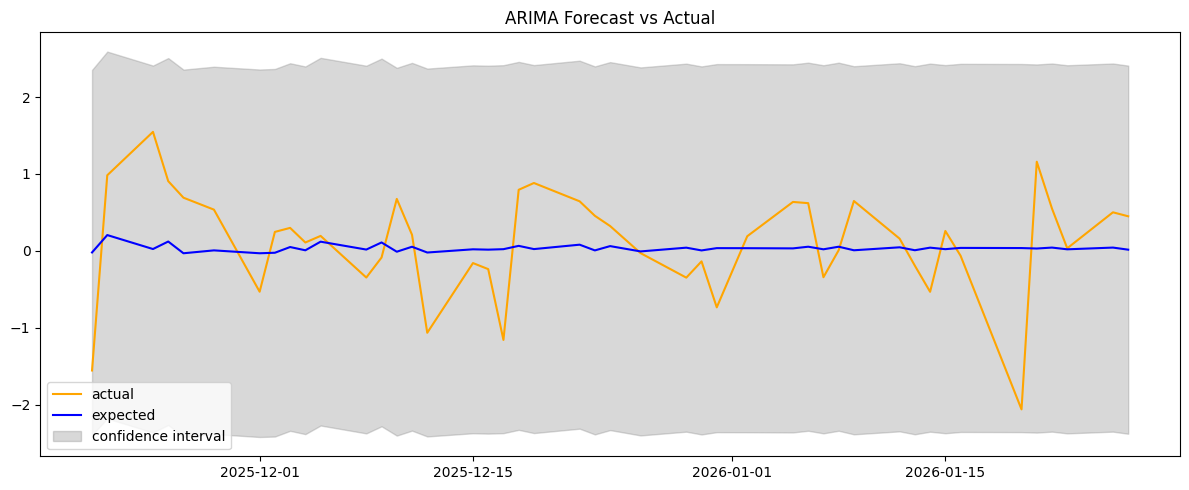

In [14]:

# Forecast
n_steps = hist_testing.shape[0]
forecast_obj = arima_fitted.get_forecast(steps=n_steps)

# Extract components
forecasted = forecast_obj.predicted_mean
forecasted_std = forecast_obj.se_mean
forecasted_bounds = forecast_obj.conf_int()

# Align forecast with test index
forecasted.index = hist_testing.index
forecasted_bounds.index = hist_testing.index

# Plot
plt.figure(figsize=(12, 5))
plt.plot(hist_testing, label='actual', color='orange')
plt.plot(forecasted, label='expected', color='blue')

# Confidence interval
plt.fill_between(
    hist_testing.index,
    forecasted_bounds.iloc[:, 0],
    forecasted_bounds.iloc[:, 1],
    color='gray',
    alpha=0.3,
    label='confidence interval'
)

plt.title("ARIMA Forecast vs Actual")
plt.legend()
plt.tight_layout()
plt.show()


In [26]:
#GARCH

#Step One: Identify Lag Orders

from arch import arch_model
dict_aic = {}

for l in range(5):
    for p in range(1, 5):
        for q in range(1, 5):
            try:
                split_date = hist_ret.index[-45]
                model = arch_model(hist_ret, mean='ARX', lags=l, vol='Garch', p=p, o=0, q=q, dist='Normal')
                res = model.fit(last_obs=split_date)
                dict_aic[(l, p, q)] = res.aic
            except:
                pass

df_aic = pd.DataFrame.from_dict(dict_aic, orient='index', columns=['aic'])
l, p, q = df_aic[df_aic.aic == df_aic.aic.min()].index[0]
print(f'ARIMA-GARCH order is ({l}, {p}, {q})')

Iteration:      1,   Func. Count:      6,   Neg. LLF: 31275916335.208
Iteration:      2,   Func. Count:     15,   Neg. LLF: 3609806622.4280205
Iteration:      3,   Func. Count:     22,   Neg. LLF: 12437.273405607424
Iteration:      4,   Func. Count:     29,   Neg. LLF: 9283.688441273836
Iteration:      5,   Func. Count:     35,   Neg. LLF: 9046.428763566208
Iteration:      6,   Func. Count:     41,   Neg. LLF: 8977.79851498306
Iteration:      7,   Func. Count:     47,   Neg. LLF: 9099.606927996607
Iteration:      8,   Func. Count:     53,   Neg. LLF: 8959.589820934567
Iteration:      9,   Func. Count:     58,   Neg. LLF: 8959.56484732488
Iteration:     10,   Func. Count:     63,   Neg. LLF: 8959.551038617006
Iteration:     11,   Func. Count:     68,   Neg. LLF: 8959.550640089972
Iteration:     12,   Func. Count:     73,   Neg. LLF: 8959.550633084875
Iteration:     13,   Func. Count:     77,   Neg. LLF: 8959.550633083967
Optimization terminated successfully    (Exit mode 0)
            

In [27]:
#Step Two: Fit the Model
model = arch_model(hist_ret, mean='ARX', lags=l, vol='Garch', p=p, o=0, q=q, dist='Normal')
res = model.fit(last_obs=split_date)

Iteration:      1,   Func. Count:     12,   Neg. LLF: 281323.4792115633
Iteration:      2,   Func. Count:     29,   Neg. LLF: 56854.52596912637
Iteration:      3,   Func. Count:     44,   Neg. LLF: 42021.21090150646
Iteration:      4,   Func. Count:     59,   Neg. LLF: 27777.707093707082
Iteration:      5,   Func. Count:     72,   Neg. LLF: 125305.0295130384
Iteration:      6,   Func. Count:     86,   Neg. LLF: 30638.25193898657
Iteration:      7,   Func. Count:    100,   Neg. LLF: 12499.361748804904
Iteration:      8,   Func. Count:    114,   Neg. LLF: 11216.770505983453
Iteration:      9,   Func. Count:    128,   Neg. LLF: 9465.192542978093
Iteration:     10,   Func. Count:    140,   Neg. LLF: 9131.502629457125
Iteration:     11,   Func. Count:    153,   Neg. LLF: 8933.412055583982
Iteration:     12,   Func. Count:    165,   Neg. LLF: 8934.015978729616
Iteration:     13,   Func. Count:    177,   Neg. LLF: 8936.966616178943
Iteration:     14,   Func. Count:    189,   Neg. LLF: 8932.96

In [28]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                  ^GSPC   R-squared:                       0.007
Mean Model:                        AR   Adj. R-squared:                  0.007
Vol Model:                      GARCH   Log-Likelihood:               -8931.08
Distribution:                  Normal   AIC:                           17882.2
Method:            Maximum Likelihood   BIC:                           17950.0
                                        No. Observations:                 6506
Date:                Tue, Jan 27 2026   Df Residuals:                     6501
Time:                        19:40:47   Df Model:                            5
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const          0.0751  1.084e-02      6.926  4.319e-12   [5.384e-02,9.634e-02]
^GSPC[1]      -0.0556  1.318e-02     -4.216  2.492e-05 [-8.140e-02,-2.973e-02]
^GSPC[2]      -0.0254  1.377e-02     -1.843  6.532e-02  [-5.236e-02,1.609e-03]
^GSPC[3]      -0.0247  1.341e-02     -1.839  6.598e-02  [-5.094e-02,1.628e-03]
^GSPC[4]      -0.0114  1.402e-02     -0.816      0.415  [-3.891e-02,1.604e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0452  9.182e-03      4.923  8.518e-07 [2.721e-02,6.320e-02]
alpha[1]       0.0928  2.028e-02      4.577  4.717e-06   [5.308e-02,  0.133]
alpha[2]       0.1278  2.011e-02      6.359  2.034e-10   [8.844e-02,  0.167]
beta[1]        0.1368      0.227      0.602      0.547     [ -0.309,  0.582]
beta[2]        0.6090      0.203      2.995  2.743e-03     [  0.210,  1.007]
============================================================================

Covariance estimator: robust
"""

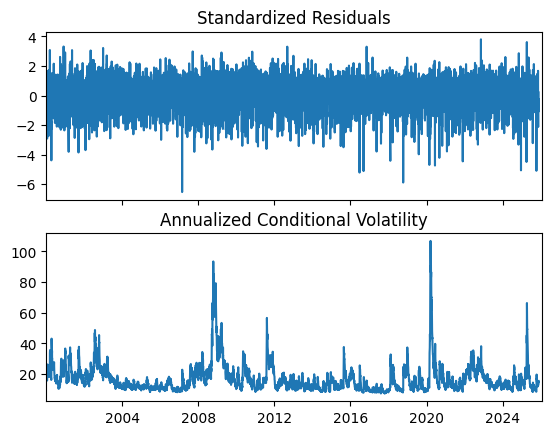

In [29]:
#Step Three: Evaluate Model via Residuals
res.plot(annualize='D')
std_resid = res.resid / res.conditional_volatility
std_resid.dropna(inplace=True)

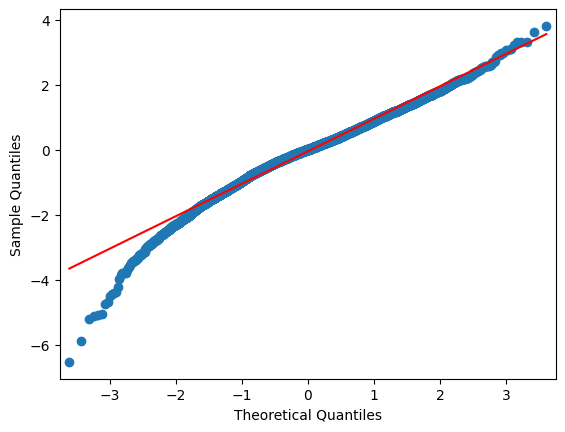

In [30]:
sm.qqplot(std_resid, line='s');

In [31]:
stat, p = normaltest(std_resid)
print(f'Statistics={stat:.3f}, p={p:.3f}')       # H0: Gaussian
stat, p = shapiro(std_resid)
print(f'Statistics={stat:.3f}, p={p:.3f}')       # H0: Gaussian

Statistics=513.673, p=0.000
Statistics=0.981, p=0.000


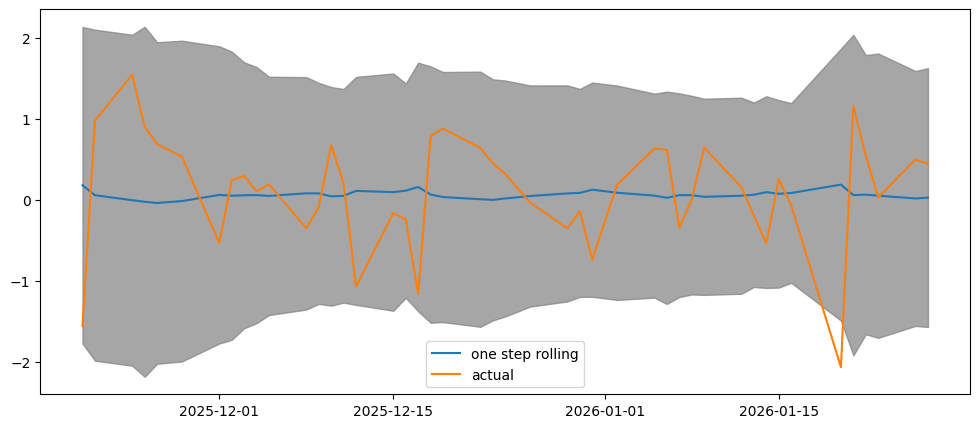

In [32]:
#Step Four: Forecast

forecasts = res.forecast(horizon=1, start=split_date)

conf = np.sqrt(forecasts.variance[split_date:])*1.96

plt.figure(figsize=(12, 5))
plt.plot(forecasts.mean[split_date:], label='one step rolling')
plt.plot(hist_ret[split_date:], label='actual')
plt.fill_between(hist_ret[split_date:].index, (forecasts.mean[split_date:]-conf).values.reshape(-1), (forecasts.mean[split_date:]+conf).values.reshape(-1), color='gray', alpha=0.7)
plt.legend()
plt.show()